# Check Data for Stationarity
Measure for the consancy of the mean, variance, and autocorrelation over time.

#### Importing Libraries

In [1]:
from __future__  import print_function, division

import pandas as pd
import numpy as np

import requests
#import cpi
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy
import copy
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

**Recall that the original Columns are:**

Product_Code - The product name encoded  
Warehouse - Warehouse name encoded  
Product_Category - Product Category for each Product_Code encoded  
Date - The date **customer** needs the product  
**Order_Demand - single order qty**  

#### Import Data 

In [2]:
# Open the pickled cleaned, transformed data
#remember that with is a "messenger" per se

with open('cleaned_product_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
#Make a copy of the dataset to ensure integrity of the original
data = df.copy()
data.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
0,0993,J,028,2012-07-27,100,2012.0,7.0,30.0,27.0,4.0


### Date Continuity
Need to make sure there is a date entry for every date between the first and last dates in the dataset.  
This will require creating a separate dataframe of dates in this case called df_all_dates.  
Create another dataframe for Product Category 019 data.
Merge those dataframes.

In [4]:
#Get the lowest and highest dates in the dataset.
data['Date'].min() , data['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [5]:
# Isolate the `Date` column that contains date of sales; 
data.set_index('Date', inplace=True)

#sort dates to ascending and view
data.sort_index(inplace=True)

In [6]:
#Create a df of all dates between the earliest and latest dates in the data
df_all_dates = pd.DataFrame(pd.date_range(start = '2012-01-01', end = '2015-12-31'))
df_all_dates.head(2)

,0
0,2012-01-01
1,2012-01-02


In [7]:
#Rename the column to exact same as column in the data set
df_all_dates = df_all_dates.rename({0:'Date'}, axis = 1)
df_all_dates.head(2)

,Date
0,2012-01-01
1,2012-01-02


In [8]:
#Create a separate df for Category 019 data
df_0019 = data[data.Product_Category == '019']
df.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
0,0993,J,028,2012-07-27,100,2012.0,7.0,30.0,27.0,4.0


In [9]:
#Merge the all_dates df with the Category 019 data

df_0019 = df_0019.merge(df_all_dates, on = 'Date', how = 'right').\
                    sort_values("Date").reset_index(drop = True)

#### Next steps replace NaNs in Order Demand

In [10]:
df_0019['Order_Demand'] = df_0019['Order_Demand'].fillna(0)
df_0019.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
0,2012-01-01,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,1195,S,019,5000.0,2012.0,1.0,1.0,2.0,0.0
2,2012-01-02,1342,S,019,30000.0,2012.0,1.0,1.0,2.0,0.0
3,2012-01-02,1391,S,019,200.0,2012.0,1.0,1.0,2.0,0.0
4,2012-01-02,1341,S,019,15000.0,2012.0,1.0,1.0,2.0,0.0


In [11]:
df_0019 = df_0019.reset_index().groupby('Date')['Order_Demand'].agg(sum)
df_0019.tail(20)

Date
2015-12-12          0.0
2015-12-13    2766500.0
2015-12-14    2903548.0
2015-12-15    4194204.0
2015-12-16    1980913.0
2015-12-17    2766425.0
2015-12-18    2739893.0
2015-12-19          0.0
2015-12-20     562500.0
2015-12-21    5212665.0
2015-12-22    3170070.0
2015-12-23      56107.0
2015-12-24    2739798.0
2015-12-25    2464167.0
2015-12-26          0.0
2015-12-27     314000.0
2015-12-28    4385271.0
2015-12-29     520476.0
2015-12-30     343700.0
2015-12-31    1787551.0
Name: Order_Demand, dtype: float64

In [12]:
df_0019 = pd.DataFrame(df_0019)

In [13]:
df_0019.shape

(1461, 1)

### Initial plots of the data

In [14]:
#resample by week
df_0019_weekly = df_0019.resample('W').sum()

In [15]:
#resample byweekly
df_0019_biweekly = df_0019.resample('2W').sum()

In [16]:
#resample byweekly
df_0019_monthly = df_0019.resample('M').sum()

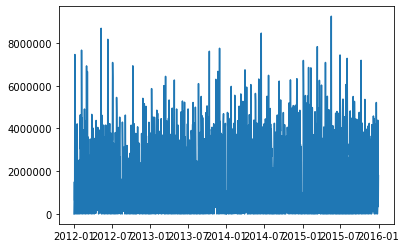

In [17]:
#Recall that df_0019 is daily orders
plt.plot(df_0019['Order_Demand'])

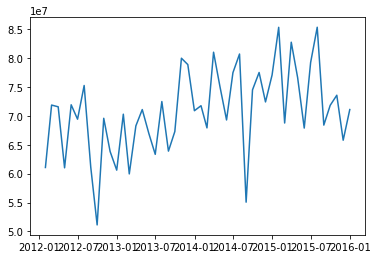

In [18]:
plt.plot(df_0019_monthly)

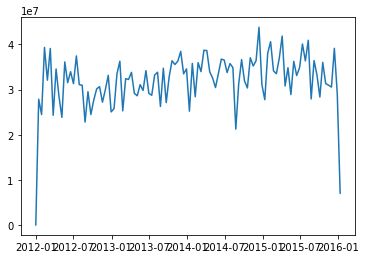

In [19]:
 plt.plot(df_0019_biweekly)

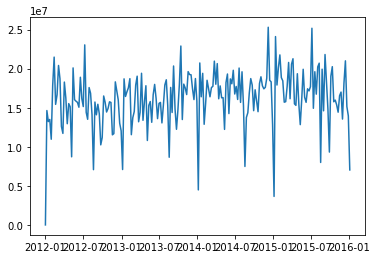

In [20]:
plt.plot(df_0019_weekly)

In [21]:
df_0019_weekly.head()

,Order_Demand
Date,
2012-01-01,0.0
2012-01-08,14635930.0
2012-01-15,13226201.0
2012-01-22,13497381.0
2012-01-29,10964325.0


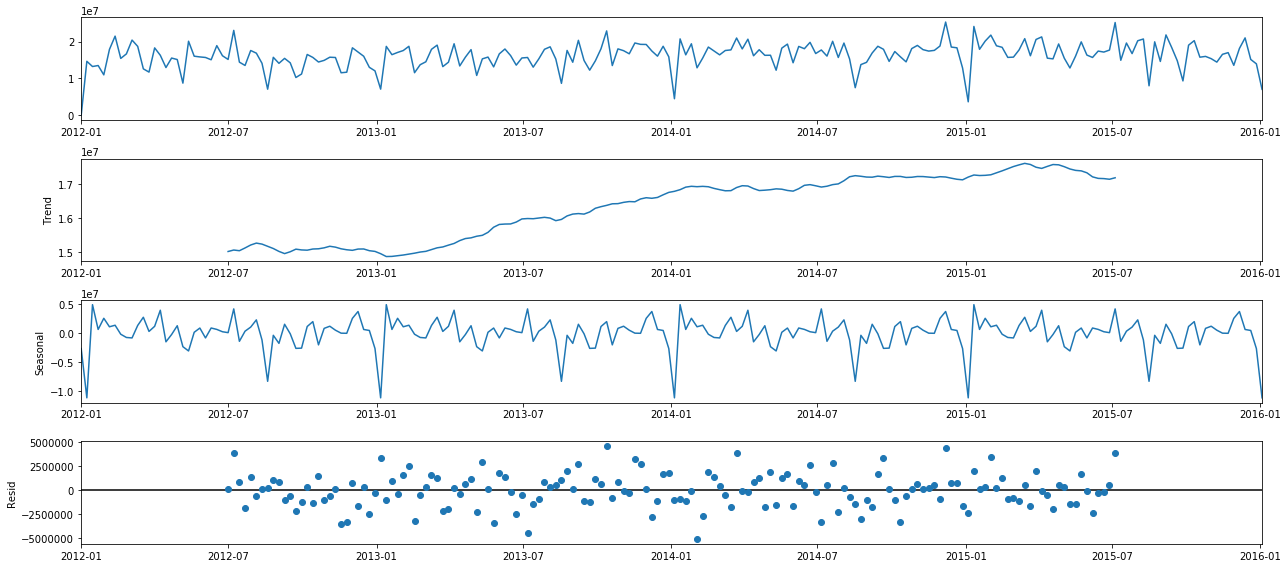

In [22]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by week
y =  df_0019.resample('W').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

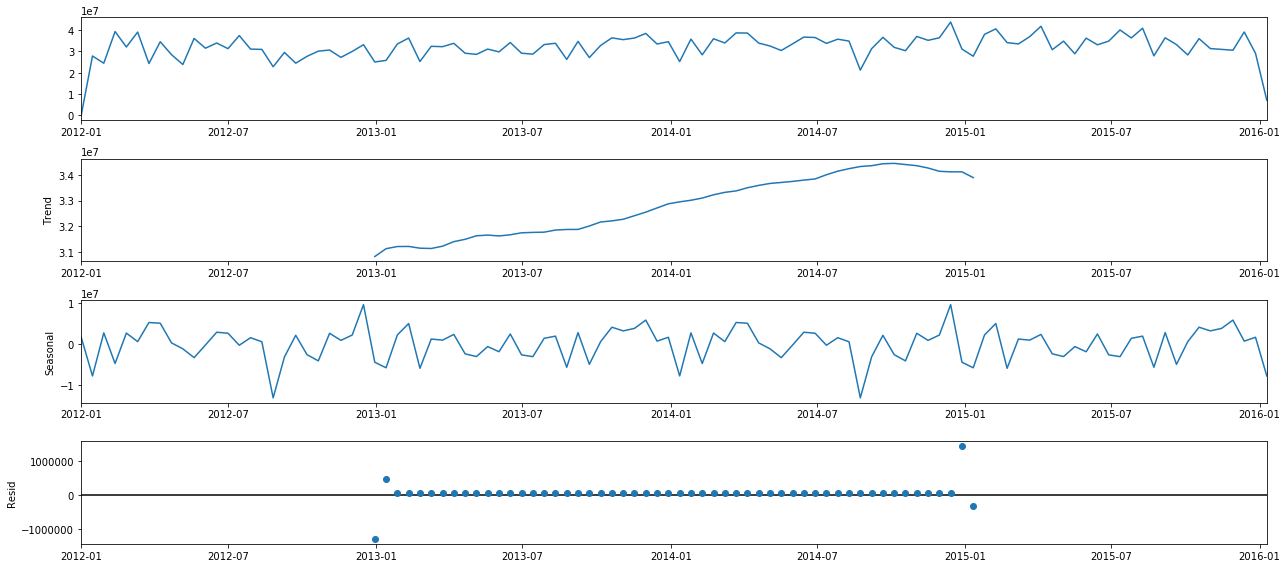

In [23]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by biweekly
y =  df_0019.resample('2W').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

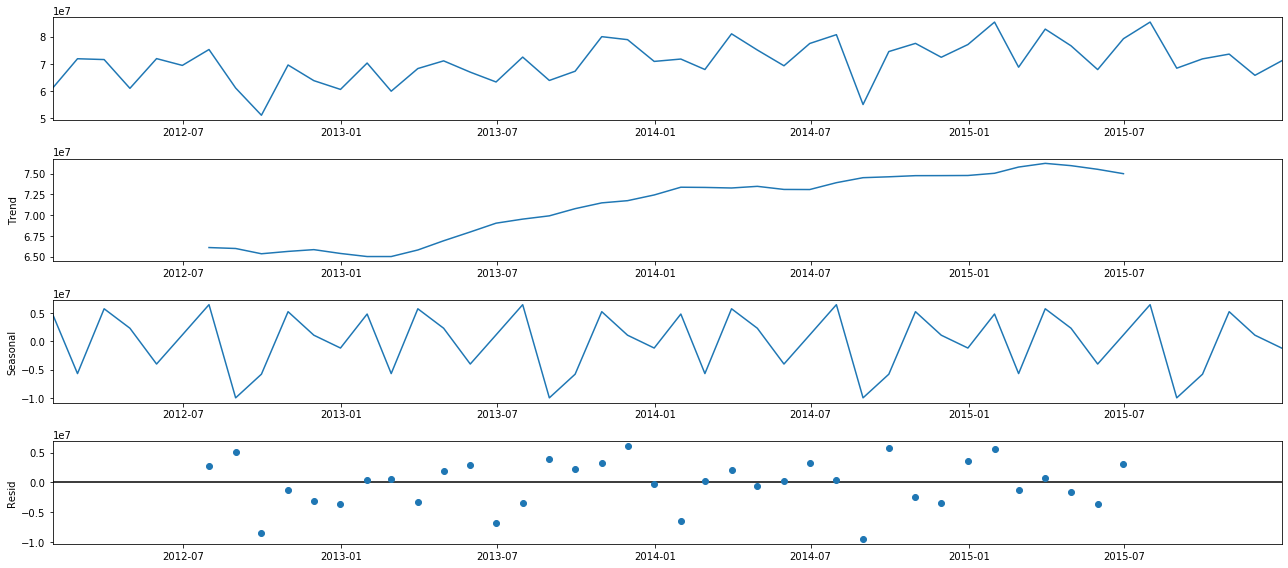

In [24]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by month
y =  df_0019.resample('M').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### There appears to be strong seasonality at the first of each year and mid-year.
This may be due to holidays.

### Stationarity evaluation

In [25]:
df_stationarity = df_0019['Order_Demand']

In [26]:
df_stationarity.head()

Date
2012-01-01          0.0
2012-01-02     653950.0
2012-01-03    1499806.0
2012-01-04     626100.0
2012-01-05    7458199.0
Name: Order_Demand, dtype: float64

In [27]:
df_stationarity.shape

(1461,)

In [28]:
df_stationarity = df_stationarity.dropna()

In [29]:
df_stationarity.shape

(1461,)

In [30]:
df_stationarity.diff()

Date
2012-01-01          NaN
2012-01-02     653950.0
2012-01-03     845856.0
2012-01-04    -873706.0
2012-01-05    6832099.0
                ...    
2015-12-27     314000.0
2015-12-28    4071271.0
2015-12-29   -3864795.0
2015-12-30    -176776.0
2015-12-31    1443851.0
Name: Order_Demand, Length: 1461, dtype: float64

In [31]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -7.744505e+00
p-value                 1.040622e-11
Lags Used               2.200000e+01
Observations Used       1.438000e+03
Critical Value (1%)    -3.434906e+00
Critical Value (5%)    -2.863552e+00
Critical Value (10%)   -2.567841e+00
dtype: float64


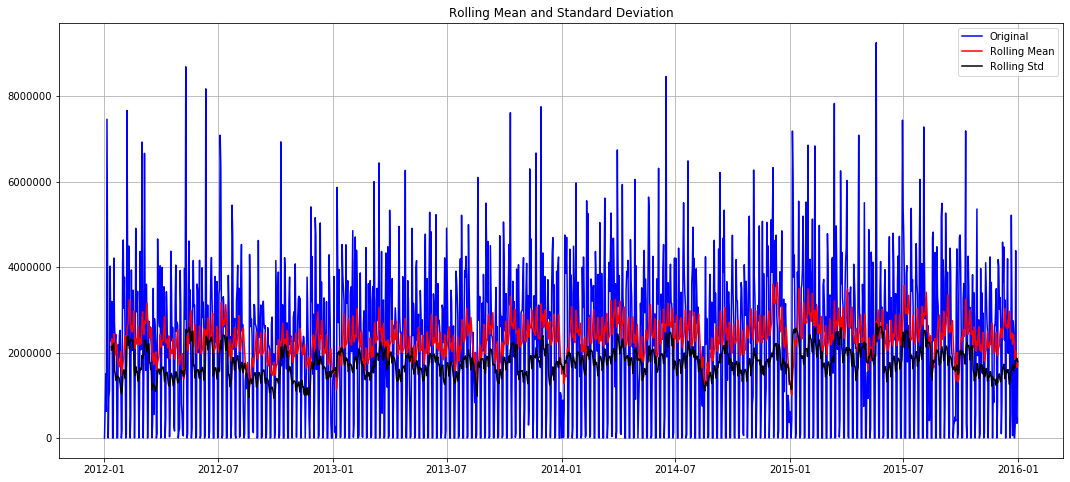

In [32]:
dftest(df_stationarity)

#### The test indicates the data is stationary

### Check for Autocorrelation
Experiment with different lags

In [33]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

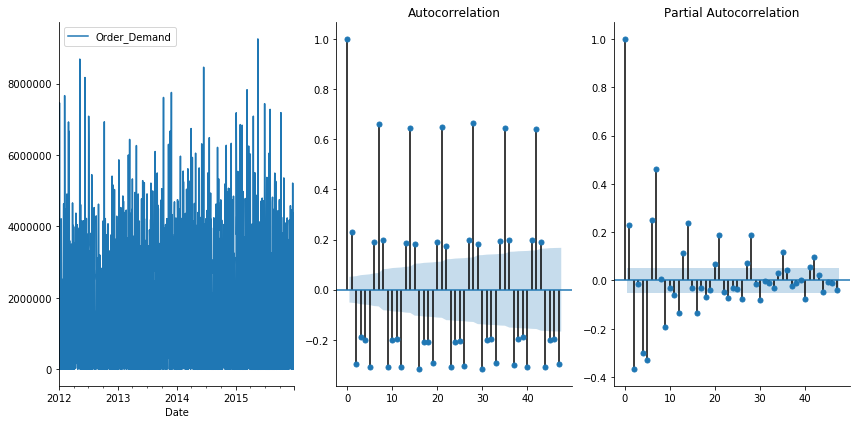

In [34]:
plots(df_0019, lags = 47)

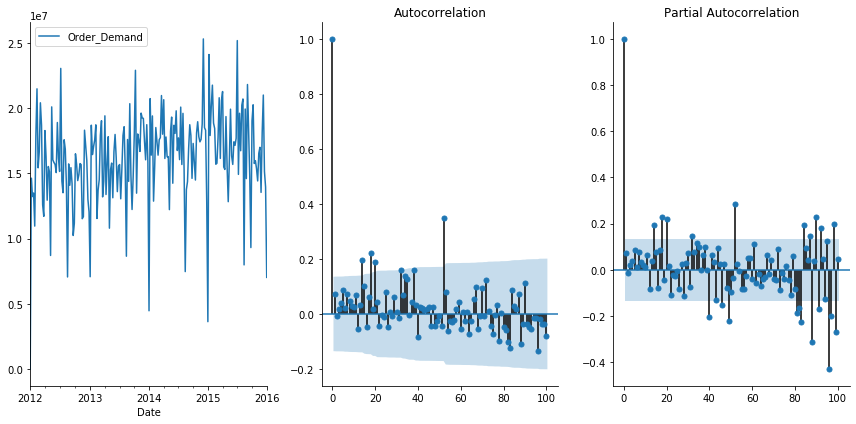

In [35]:
plots(df_0019_weekly, lags = 100)

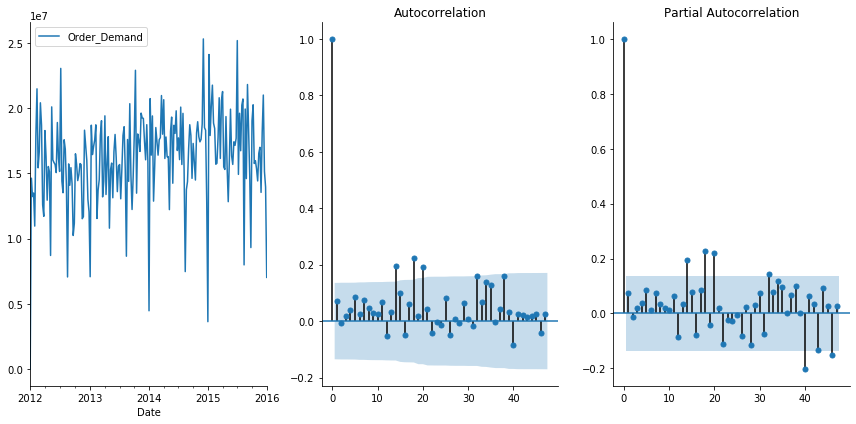

In [36]:
plots(df_0019_weekly, lags = 47)

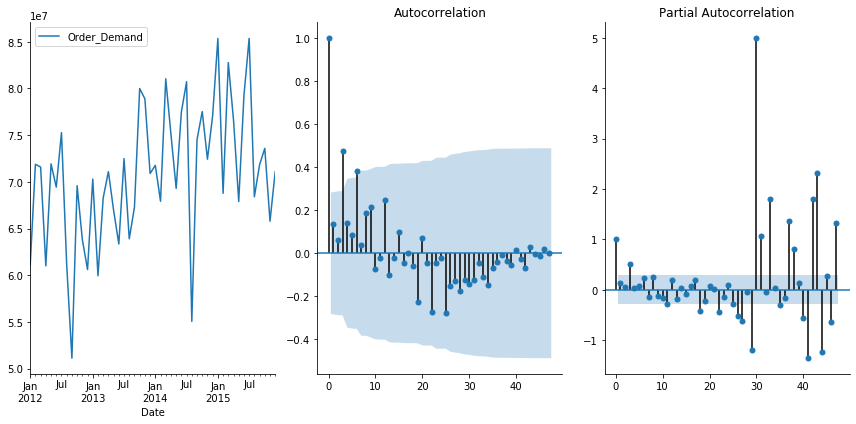

In [37]:
plots(df_0019_monthly, lags = 47)

#### There definitely seems to be autocorrelation particularly at 52 weeks intervals.
Need to ensure the model is recognizing those relationships

### Next step is to Model
Will use SARIMA model in the next notebook.